<img src="../Images/UniLogo.png" height=50 align="left"/> <img src="../Images/ibbLogo.png" height=50 align="right"/>

# Non-linear Computational Mechanics of Structures
## Exercise 11 - Summer term 2024

### Cantilever subjected to End Shear Force
The problem is adopted from Sze et al. (2004). Refer task sheet for further details on the problem.

#### Import all packages
The first step is to import the necessary packages. From `ikarus`, we import `finite_elements`, which contains the Python bindings for the different finite elements in Ikarus; `assembler` to assemble different local element quantities to global quantities (available both in sparse and dense formats for matrices); and `utils` that contain certain utility functions, for example, to apply Dirichlet boundary conditions. Furthermore, from `dune.vtk`, `vtkUnstructuredGridWriter` is imported to write the results in a `*.vtu` file that can then be examined using ParaView. Since the finite elements are according to the Kirchhoff-Love shell theory that requires $C^1$-continuity between elements, we will use NURBS as basis functions obtained from `dune.iga.bases`. Finally, there are some helper functions implemented in `helperfunctions.py` that are also imported.

In [2]:
import sys

sys.path.append("../")

%matplotlib inline

from helperfunctions import (
    globalBasis,
    cantileverBeam,
    cantileverBeamRef,
    loadDisplacement,
)

import ikarus as iks
from ikarus import finite_elements, assembler, utils

from dune.vtk import vtkUnstructuredGridWriter

import numpy as np
import scipy as sp
import pyvista as pv

from dune.iga.basis import Power, Nurbs

We next define the input parameters based on the problem description.

In [3]:
Emod = 1.2e6  # Young's Modulus
nu = 0.0  # Poisson's Ratio
L = 10.0  # Length of the beam
b = 1.0  # Width of the beam
h = 0.1  # Thickness of the beam
P0 = (Emod * b * h**3 / 12.0) / L**2  # P0 = 1
Pmax = 4.0 * P0  # Maximum applied traction load
filename = "cantilever"  # Filename for the *.vtu file to be saved

#### Grid and basis functions
The `grid` corresponding to the cantilever beam problem can be obtained via the helper function `cantileverBeam`, which takes in as arguments the length and width of the beam and also the number of refinement steps to be performed along the length. We then get the `NURBS` basis that represents the underlying `grid`. This is then wrapped with a `Power` basis, denoting that all three degrees of freedom at a node are approximated using the same NURBS functions. It is important to note that the `cantileverBeam` function assumes that the number of elements in the width direction is one and the polynomial order of the underlying basis functions is 2.

In [4]:
grid = cantileverBeam(L, b, 5)
basis = globalBasis(grid, Power(Nurbs(), 3))
flatBasis = basis.flat()  # FlatLexicographic
order = 2  # fixed
neleX = grid.size(0)  # Total number of elements
neleY = 1

In [5]:
nCPX = neleX + order  # Number of control points in x-direction
nCPY = neleY + order  # Number of control points in y-direction

In [6]:
print("We have {} dofs.".format(len(flatBasis)))
print("We have {} vertices.".format(grid.size(2)))
print("We have {} elements.".format(grid.size(0)))

We have 306 dofs.
We have 66 vertices.
We have 32 elements.


#### Traction load
For a given traction load $\hat{\boldsymbol{t}}$ at the boundary $\Gamma_{\sigma,e}$ of an element $e$, the vector of consistent nodal forces can be computed via
$$
\boldsymbol{f_{\text{ext}}} = \int_{\Gamma_{\sigma,e}}{\boldsymbol{\text{N}}^{\text{T}} \,\, \hat{\boldsymbol{t}}}\,\,\text{d}\Gamma
$$
For the given problem, $\hat{\boldsymbol{t}} = \left[0,0,\lambda P_{\text{max}}\right]^{\text{T}}$.
This traction load $\hat{\boldsymbol{t}}$ is defined via the function `nL`, while the boundary $\Gamma_{\sigma,e}$ is defined using a `boundaryPatch`. 
These can then be used to defined the `neumannLoad`.

In [7]:
def nL(x, lambdaVal):
    return np.array([0, 0, lambdaVal])


neumannVertices = np.zeros(grid.size(2), dtype=bool)


def loadTopEdgePredicate(x):
    return True if x[0] > L - 1e-8 else False


indexSet = grid.indexSet
for v in grid.vertices:
    neumannVertices[indexSet.index(v)] = loadTopEdgePredicate(v.geometry.center)

boundaryPatch = utils.boundaryPatch(grid, neumannVertices)

neumannLoad = finite_elements.neumannBoundaryLoad(boundaryPatch, nL)

#### Vector of finite elements
The vector of finite elements `fes` with the skills `kirchhoffLoveShell` and `neumannLoad` is created next.

In [8]:
klShell = finite_elements.kirchhoffLoveShell(youngs_modulus=Emod, nu=nu, thickness=h)

fes = []
for ele in grid.elements:
    fes.append(iks.finite_elements.makeFE(basis, klShell, neumannLoad))
    fes[-1].bind(ele)

#### Dirichlet boundary conditions
The left edge of the cantilever is expected to be clamped. In order to do this, we first fix the displacement degrees of freedom $u,v,w$ via the function `fixBoundaryDOFsUsingLocalViewAndIntersection` that takes in a functor describing the left edge called `fixLeftEdge`. Since there are no rotational degrees of freedom for Kirchhoff-Love-type shell finite elements, we also fix the displacement degrees of freedom at the control points that are immediately adjacent to the control points at $x=0$. This workaround works for such $C^1$-continuous NURBS basis functions directly. Furthermore, the global indices corresponding to these control points are obtained manually here, but a wrapper to have such functionality is one of the [open tasks](https://ikarus-project.github.io/dev/03_contribution/openTask/) of Ikarus.

In [9]:
dirichletBC = iks.dirichletValues(flatBasis)


def fixLeftEdge(vec, localIndex, localView, intersection):
    for j in range(nCPY):
        for i in range(nCPY):
            idx = (nCPX) * (nCPY) - 1
            vec[(nCPX) * 1 * i + j * idx + j + 1] = (
                True  # workaround to have a clamped boundary condition for the Kirchhoff-Love Shell
            )
    if intersection.geometry.center[0] < 1e-8:
        vec[localView.index(localIndex)] = True


dirichletBC.fixBoundaryDOFsUsingLocalViewAndIntersection(fixLeftEdge)

#### Dense Assembler
We pass the vector of finite elements and the object describing the Dirichlet boundary conditions to a dense flat assembler, which could then provide the global assembled quantities after considering the Dirichlet boundary conditions. For the problem at hand, the assembler is used to assemble the stiffness matrix and the residual vector.

In [10]:
denseAssembler = assembler.denseFlatAssembler(fes, dirichletBC)
print("We fix {} dofs.".format(len(flatBasis) - denseAssembler.reducedSize()))

We fix 18 dofs.


#### Assembler and Post-processing Functions
`gradAndhess` is defined here to obtain the assembled gradient (here, the residual) and hessian (here, the tangent stiffness matrix). It takes in the current displacement and the load factor as input arguments. `writeVTK` is a wrapper function to write the necessary `*.vtu` files. It takes a displacement state and an increment number that will be suffixed with the file name as arguments.

In [11]:
def gradAndhess(disp, loadFactor):
    req = fes[0].createRequirement()
    req.insertParameter(iks.ValueWrapper(loadFactor))
    req.insertGlobalSolution(disp)
    g = denseAssembler.vector(req, iks.VectorAffordance.forces, iks.DBCOption.Full)
    h = denseAssembler.matrix(req, iks.MatrixAffordance.stiffness, iks.DBCOption.Full)
    return g, h


def writeVTK(disp, increment):
    vtkWriter = vtkUnstructuredGridWriter(grid)
    dispFunc = flatBasis.asFunction(disp)
    vtkWriter.addPointData(dispFunc, name="displacement")
    vtkWriter.write(filename + str(increment))

#### Newton-Raphson Method
The Newton-Raphson method is implemented here that will be later used as a non-linear solver by the load control method.

In [12]:
def NewtonRaphson(disp, loadfactor):
    maxiter = 25
    tol = 1e-8
    success = False
    for k in range(maxiter):
        R, K = gradAndhess(disp, loadfactor)
        r_norm = np.linalg.norm(R)

        deltad = sp.linalg.solve(K, R)
        disp -= deltad
        print(
            "Iteration ",
            k,
            "Residual Norm ",
            r_norm,
            "Correction Norm ",
            np.linalg.norm(deltad),
            "Rank of K ",
            np.linalg.matrix_rank(K),
        )
        if r_norm < tol:
            success = True
            break
    return disp, k + 1, success

#### Load Control Method

The load control method is used to solve the given problem. The number of increments is set to 50. This is then used to calculate the step size such that the simulation ends at $P=P_{\text{max}}$. If the non-linear solver used converges, the `writeVTK` function is called, and the deformation can then be viewed via ParaView.

In [13]:
num_increments = 50
step_size = Pmax / (num_increments - 1)
print("Step Size ", step_size)

d = np.zeros(len(flatBasis))
lambdaLoad = 0.0
totalIterations = 0

lf = np.zeros(num_increments)  # load factors
ufe = np.zeros(
    num_increments
)  # absolute value of horizontal displacement (x-direction)
wfe = np.zeros(num_increments)  # absolute value of vertical displacement (z-direction)

for inc in range(num_increments):
    print("Increment ", inc, "Load Factor ", lambdaLoad)
    result = NewtonRaphson(d, lambdaLoad)
    d = result[0]  # displacement

    # store results for post-processing
    lf[inc] = lambdaLoad
    uidx = (nCPX) * (nCPY) - 1
    widx = (nCPX) * (nCPY) * 3 - 1
    ufe[inc] = abs(d[uidx])
    wfe[inc] = abs(d[widx])

    lambdaLoad += step_size
    totalIterations += result[1]  # Total iterations update
    if result[2]:  # Check if the nonlinear solver converged
        writeVTK(d, inc)
    else:
        print("NEWTON-RAPHSON METHOD FAILED TO CONVERGE !!!")
        break

print("Total Iterations ", totalIterations)

Step Size  0.08163265306122451
Increment  0 Load Factor  0.0
Iteration  0 Residual Norm  0.0 Correction Norm  0.0 Rank of K  306
Increment  1 Load Factor  0.08163265306122451
Iteration  0 Residual Norm  0.0471306342195613 Correction Norm  1.376652302785346 Rank of K  306
Iteration  1 Residual Norm  58.80631191122973 Correction Norm  0.02052839701944223 Rank of K  306
Iteration  2 Residual Norm  0.07342182112946706 Correction Norm  0.00025190280054223973 Rank of K  306
Iteration  3 Residual Norm  6.406769375388501e-07 Correction Norm  4.558934302751832e-06 Rank of K  306
Iteration  4 Residual Norm  7.740377762796581e-10 Correction Norm  2.5818745063102006e-12 Rank of K  306
Increment  2 Load Factor  0.16326530612244902
Iteration  0 Residual Norm  0.0471306342195097 Correction Norm  1.3743019702932138 Rank of K  306
Iteration  1 Residual Norm  58.5916371544939 Correction Norm  0.02045876592259023 Rank of K  306
Iteration  2 Residual Norm  0.07288636580145869 Correction Norm  0.0023781166

#### Load-displacement curve
The reference solutions are adapted from **Table 2a** of *Sze et al. 2004*. These are then compared with the solution obtained here from Ikarus.

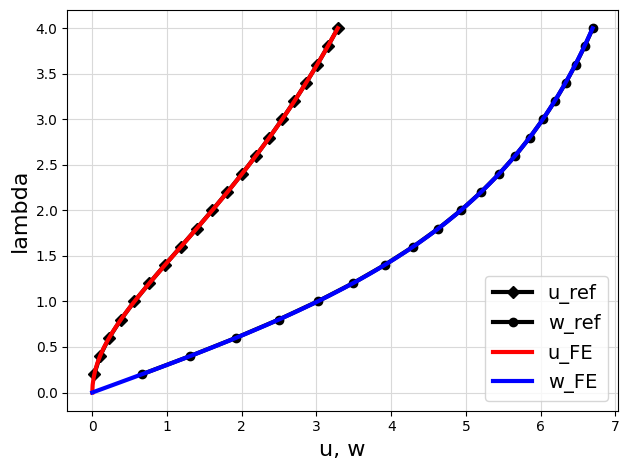

In [14]:
# load reference solutions
lfref, uref, wref = cantileverBeamRef(P0, Pmax)

loadDisplacement(lfref, uref, wref, lf, ufe, wfe)

#### Visualize deformed configuration via PyVista

/dune/dune-common/build-cmake/dune-env/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/dune/dune-common/build-cmake/dune-env/lib/python3.11/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


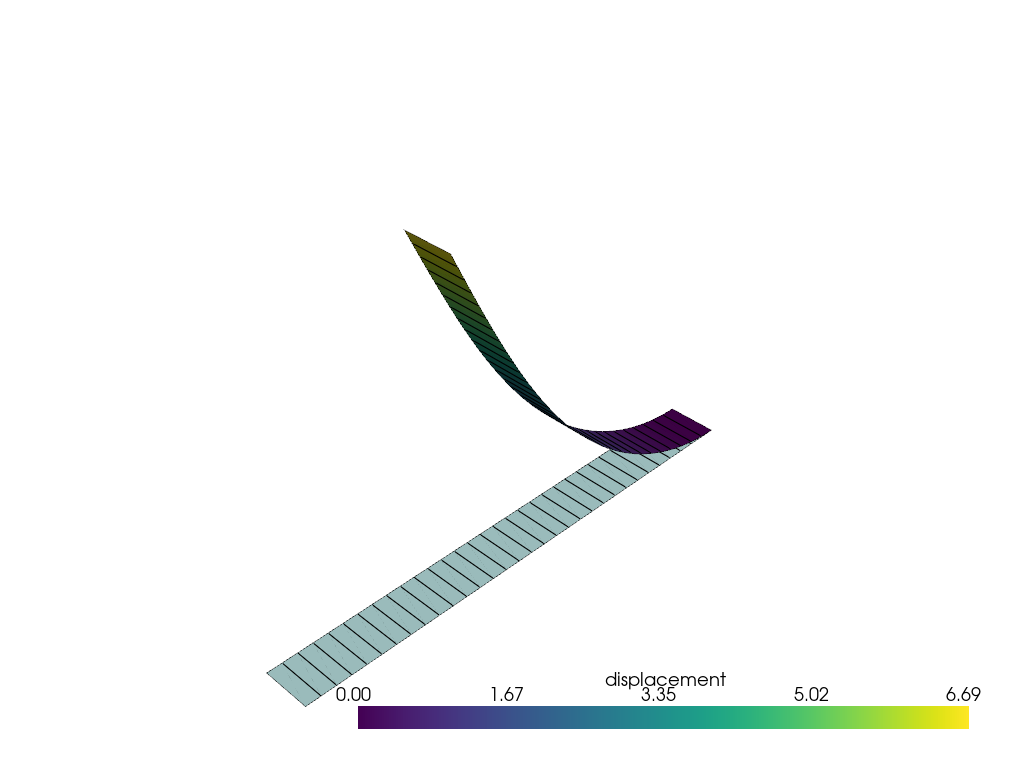

In [15]:
meshUndeformed = pv.UnstructuredGrid(filename + str(0) + ".vtu")
meshDeformed = pv.UnstructuredGrid(filename + str(inc) + ".vtu").warp_by_vector()
plotter = pv.Plotter(off_screen=False)
plotter.add_mesh(meshUndeformed, show_edges=True)
plotter.add_mesh(meshDeformed, scalars="displacement", component=2, show_edges=True)
plotter.show()